# Machine Learning model for non-invasive diagnosis of heart disease

### Importing libraries
pyspark, numpy, pandas, matplotlib, seaborn, sklearn, keras



In [64]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import DataFrameReader
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import *

In [65]:
spark = SparkSession \
    .builder \
    .appName('pyspark_demo_app') \
    .config('spark.driver.extraClassPath',
            'postgresql-42.2.9') \
    .master("local[*]") \
    .getOrCreate()

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Importing necessary libraries from sklearn

Importing the following Machine Learning algorithms for model building.
1. K Neighbors Classifier
2. Support Vector Classifier
3. Decision Tree Classifier
4. Random Forest Classifier
5. Sequential

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


### Connecting to dataset in PostgreSql database in AWS

Credentials are required to connect to the database

In [68]:
# dataset = pd.read_csv('dataset.csv')
# tips on jdbc ... https://sparkour.urizone.net/recipes/using-jdbc/#03
# Load properties from file
import json
with open("../data-load/Resources/db-properties.json") as propertyFile:
    properties = json.load(propertyFile)

dbMode = "overwrite"
jdbc_url= properties["jdbcUrl"]
dbConfig = {"user": properties["user"], 
          "password": properties["password"], 
          "driver": properties["driver"]
         }

In [69]:
entireDF = spark.read.jdbc(url=jdbc_url, table = 'heart_ml_cleveland', properties=dbConfig)
entireDF.printSchema()
entireDF.limit(5).show()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: double (nullable = true)
 |-- thal: double (nullable = true)
 |-- num: integer (nullable = true)
 |-- target: integer (nullable = true)

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+------+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|target|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+------+
|63.0|1.0|1.0|   145.0|233.0|1.0|    2.0|  150.0|  0.0|    2.3|  3.0|0.0| 6.0|  0|     0|
|37.0|1.0|3.0|   130.0|250.0|0.0|    0.0|  187.0|  0.0|    3.5|  3.0|0.0| 3.0|  0| 

## Exploratory Data Analysis

In [70]:
#convert to pandas df
dataset = entireDF.select("*").toPandas()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
age         303 non-null float64
sex         303 non-null float64
cp          303 non-null float64
trestbps    303 non-null float64
chol        303 non-null float64
fbs         303 non-null float64
restecg     303 non-null float64
thalach     303 non-null float64
exang       303 non-null float64
oldpeak     303 non-null float64
slope       303 non-null float64
ca          299 non-null float64
thal        301 non-null float64
num         303 non-null int32
target      303 non-null int32
dtypes: float64(13), int32(2)
memory usage: 33.3 KB


Dataset has total of 303 records with 4 missing values, 13 features. 'num' and 'target' correspond to the same column just that labels in num are 0 for absence of heart disease and 1,2,3,4 for presence.Hence, this is a classification problem. The 'target' column was added as a part of ETL before loading to db. Here 1,2,3,4 (in 'num') have been replaced with 1 to correspond to presence of heart disease. 

In [71]:
#Drop null values as there are total 4 values, this should not make much difference
dataset=dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 298
Data columns (total 15 columns):
age         297 non-null float64
sex         297 non-null float64
cp          297 non-null float64
trestbps    297 non-null float64
chol        297 non-null float64
fbs         297 non-null float64
restecg     297 non-null float64
thalach     297 non-null float64
exang       297 non-null float64
oldpeak     297 non-null float64
slope       297 non-null float64
ca          297 non-null float64
thal        297 non-null float64
num         297 non-null int32
target      297 non-null int32
dtypes: float64(13), int32(2)
memory usage: 34.8 KB


In [72]:
dataset=dataset.drop(columns='num', axis=1)
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
2,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
3,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
4,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0


In [73]:
#Examine the dataset to identify scale of values
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


The minimum and maximum values for continuous feature columns like 'age', 'chol', 'thalach' etc. are in different scales.

In [44]:
# #pip install pandas-profiling[notebook,html]
# import pandas_profiling as pp
# from pandas_profiling import ProfileReport

In [62]:
# #EDA with pandas profiling(https://github.com/pandas-profiling/pandas-profiling)
# profile=ProfileReport(dataset, title='Pandas Profiling Report for cleveland dataset',  html={'style':{'full_width':True}})
# profile.to_notebook_iframe()

### Correlation matrix to check for data redundancy



In [48]:
# rcParams['figure.figsize'] = 20, 14
# plt.matshow(dataset.corr())
# plt.yticks(np.arange(dataset.shape[1]), dataset.columns)
# plt.xticks(np.arange(dataset.shape[1]), dataset.columns)
# plt.colorbar()

Taking a look at the correlation matrix above, it's easy to see that a few features have negative correlation with the target value while some have positive.
Next, I'll take a look at the histograms for each variable.

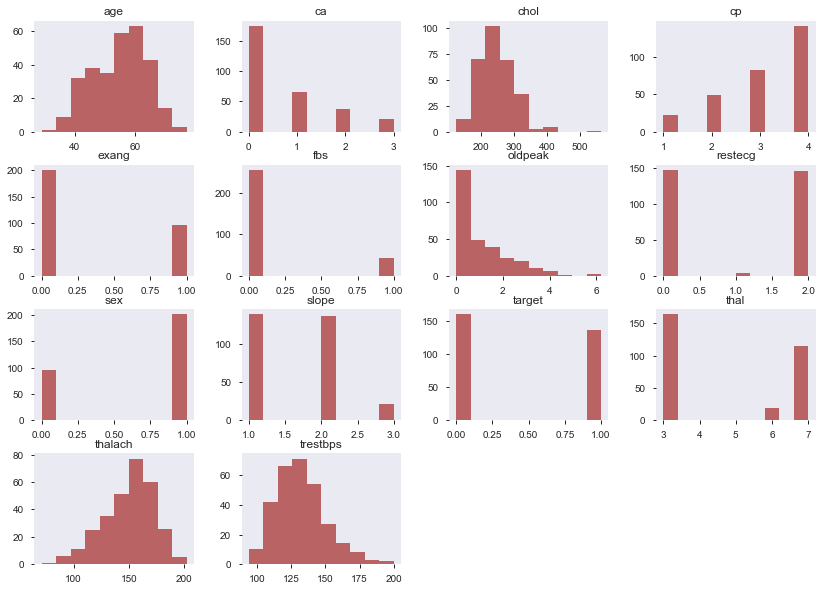

In [80]:
dataset.hist(figsize=(14,10), color="brown",alpha=0.7, grid=False);

The histograms suggest that there are 5 continuous features, and rest categorical and each feature has a different range of distribution. Age, thalach, trestbps seem to be very close to a normal distribution. Oldpeak and Chol are somewhat skewed. While within categorical features, the ratio for each class is not equal. Good thing is that datapoints in the target are comparable in both classes (0,1).

In [24]:
# dataset['num']=dataset['num'].replace(['1', '2','3', '4'],'1')
# #     value=1,
# #     inplace=True)
# dataset
# dataset['num']=dataset.loc[dataset['num'].isin(['1', '2','3', '4'])]='1'
# dataset
# dataset['num'].value_counts()

### Examine distribution of datapoints in the target 

In [91]:
#Check count
a,b=np.bincount(dataset.target)
print(f"Percentage of data distribution in the two classes are:")
print(round(a/(a+b)*100,2))
print(round(b/(a+b)*100,2))

Percentage of data distribution in the two classes are:
53.87
46.13


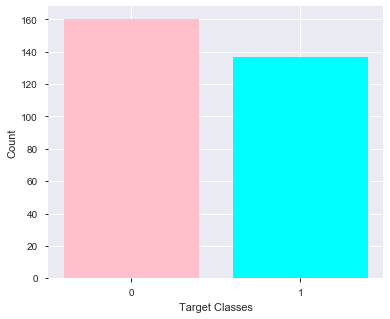

In [82]:
#Visualize
rcParams['figure.figsize'] = 6,5
plt.bar(dataset['target'].unique(), dataset['target'].value_counts(), color = ['pink','cyan'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count');

Data distribution in the target suggests it is a balanced dataset, hence we don't need to use stratify during data splitting.

## Data Pre-Processing

From EDA, it is clear that the data needs to be scaled before proceeding and categorical variables need to be converted to dummy variables.

In [92]:
#Processing categorical features
dataset = pd.get_dummies(dataset, columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'])
dataset.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0.0,sex_1.0,cp_1.0,cp_2.0,...,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,145.0,233.0,150.0,2.3,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
1,37.0,130.0,250.0,187.0,3.5,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,0
2,41.0,130.0,204.0,172.0,1.4,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
3,56.0,120.0,236.0,178.0,0.8,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
4,57.0,120.0,354.0,163.0,0.6,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [94]:
#Scaling continuous features
standardScaler = StandardScaler()
columns_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])
dataset.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0.0,sex_1.0,cp_1.0,cp_2.0,...,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
0,0.936181,0.750380,-0.276443,0.017494,1.068965,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
1,-1.941680,-0.095506,0.051047,1.633010,2.099753,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,0
2,-1.498933,-0.095506,-0.835103,0.978071,0.295874,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
3,0.161372,-0.659431,-0.218651,1.240047,-0.219520,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
4,0.272059,-0.659431,2.054515,0.585108,-0.391318,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0


### Split data to train and test sets



In [111]:
#Stratify=y when used doesn't show much variation, since data is balanced. Hence removed
y = dataset['target']
X = dataset.drop(['target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0, stratify=y)


In [113]:
# Check if the labels are well shuffled in train and test set
a,b=np.bincount(y_train)
print(f"Percentage of data distribution in the train set:")
print(round(a/(a+b)*100,2))
print(round(b/(a+b)*100,2))
print("-------------------")
x,y=np.bincount(y_test)
print(f"Percentage of data distribution in the test set:")
print(round(x/(x+y)*100,2))
print(round(y/(x+y)*100,2))
# np.bincount(y_test)

Percentage of data distribution in the train set:
57.58
42.42
-------------------
Percentage of data distribution in the test set:
46.46
53.54


Data labels are well distributed in both train and test sets

## Applying Machine Learning Algorithms

### Logistic Regression

In [144]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
# Create an instance of Logistic Regression Classifier and fit the data.
lg.fit(X_train,y_train)
lg_score=round(lg.score(X_train,y_train)*100,2)
lg_score

86.36


### K Neighbors Classifier

The classification parameters are values of neighbors (k) and distance. Different values of neighbours will be used to check the best output score. 

In [121]:
#Hold the cores for various neighbors i.e. k in a list
knn_scores = []
for i in range(1,20):
    knn_classifier = KNeighborsClassifier(n_neighbors = i)
    knn_classifier.fit(X_train, y_train)
    knn_scores.append(round(knn_classifier.score(X_test, y_test)*100,2))
        
knn_scores

[79.8,
 74.75,
 81.82,
 79.8,
 83.84,
 80.81,
 82.83,
 82.83,
 82.83,
 81.82,
 81.82,
 81.82,
 86.87,
 84.85,
 86.87,
 84.85,
 83.84,
 84.85,
 86.87]

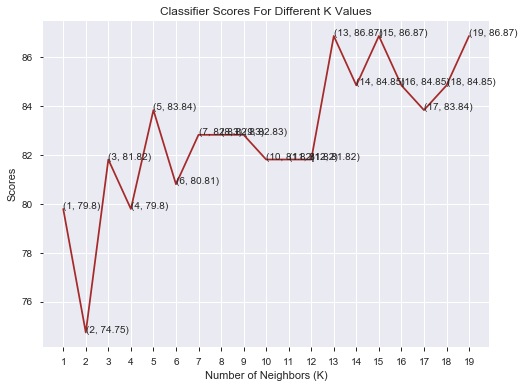

In [141]:
rcParams['figure.figsize'] = 8,6
plt.plot([i for i in range(1, 20)], knn_scores, color = 'brown' )
for i in range(1,20):
    plt.text(i, knn_scores[i-1], (i, knn_scores[i-1]))
#     plt.text(i, knn_scores[i-1])

plt.xticks([i for i in range(1, 20)])
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Scores')
plt.title('Classifier Scores For Different K Values');

The maximum score is achieved as 86.87 for k=13, 15, 19 neighbors.

### Support Vector Classifier

First testing all kernels.
Second, select the best kernel and perform Hyperparameter Tuning


In [134]:
svc_scores = []
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernels)):
    svc_classifier = SVC(kernel = kernels[i])
    svc_classifier.fit(X_train, y_train)
    svc_scores.append(round(svc_classifier.score(X_test, y_test)*100,2))


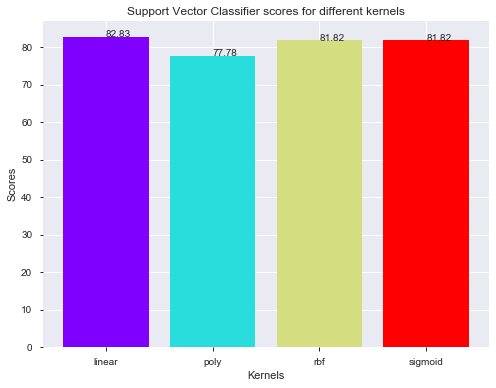

In [140]:
rcParams['figure.figsize'] = 8,6
colors = rainbow(np.linspace(0, 1, len(kernels)))
plt.bar(kernels, svc_scores, color = colors)
for i in range(len(kernels)):
    plt.text(i, svc_scores[i], svc_scores[i])
plt.xlabel('Kernels')
plt.ylabel('Scores')
plt.title('Support Vector Classifier scores for different kernels');

## Hyperparameter Tuning

Using GridSearchCV to tune the model's parameters, gamma and rgularization(C) using linear kernel

In [137]:
from sklearn.model_selection import GridSearchCV
model = SVC(kernel='linear')
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
# svc_classifier = SVC(kernel = 'linear',
grid = GridSearchCV(model, param_grid, verbose=3)
# Train the model with GridSearch
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.725, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.850, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.750, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.846, total=   0.0s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.872, total=   0.0s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.725, total=   0.0s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=5, gamma=0.0005, score=0.800, total=   0.0s
[CV] C=5, gamma=0.0005 ...............................................
[CV] ................... C=5, gamma=0.0005, score=0.700, total=   0.0s
[CV] C=5, gamma=0.0005 ...............................................
[CV] ................... C=5, gamma=0.0005, score=0.821, total=   0.0s
[CV] C=5, gamma=0.0005 ...............................................
[CV] ................... C=5, gamma=0.0005, score=0.872, total=   0.0s
[CV] C=5, gamma=0.001 ................................................
[CV] .................... C=5, gamma=0.001, score=0.750, total=   0.0s
[CV] C=5, gamma=0.001 ................................................
[CV] .................... C=5, gamma=0.001, score=0.800, total=   0.0s
[CV] C=5, gamma=0.001 ................................................
[CV] .................... C=5, gamma=0.001, score=0.700, total=   0.0s
[CV] C=5, gamma=0.001 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 5, 10, 50],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [138]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'gamma': 0.0001}
0.8085897435897437


In [151]:
# Training score:
grid.score(X_train, y_train)
# Testing score:
grid.score(X_test, y_test)

0.8282828282828283

#### Decision Tree Classifier

Here, I'll use the Decision Tree Classifier to model the problem at hand. I'll vary between a set of `max_features` and see which returns the best accuracy.

In [35]:
dt_scores = []
for i in range(1, len(X.columns) + 1):
    dt_classifier = DecisionTreeClassifier(max_features = i, random_state = 0)
    dt_classifier.fit(X_train, y_train)
    dt_scores.append(dt_classifier.score(X_test, y_test))

I selected the maximum number of features from 1 to 30 for split. Now, let's see the scores for each of those cases.

Text(0.5, 1.0, 'Decision Tree Classifier scores for different number of maximum features')

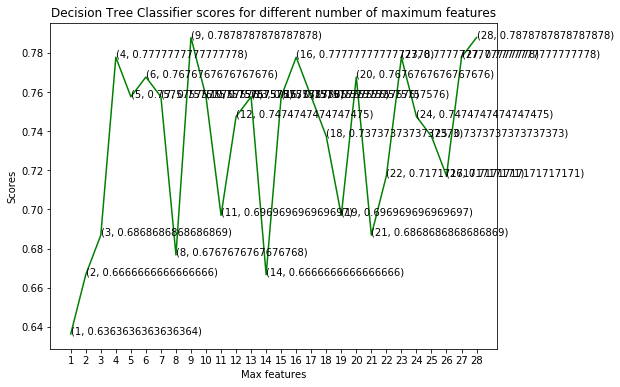

In [36]:
plt.plot([i for i in range(1, len(X.columns) + 1)], dt_scores, color = 'green')
for i in range(1, len(X.columns) + 1):
    plt.text(i, dt_scores[i-1], (i, dt_scores[i-1]))
plt.xticks([i for i in range(1, len(X.columns) + 1)])
plt.xlabel('Max features')
plt.ylabel('Scores')
plt.title('Decision Tree Classifier scores for different number of maximum features')

The model achieved the best accuracy at three values of maximum features, `2`, `4` and `18`.

In [38]:
print("The score for Decision Tree Classifier is {}% with {} maximum features.".format(dt_scores[17]*100, [9,28]))

The score for Decision Tree Classifier is 73.73737373737373% with [9, 28] maximum features.


#### Random Forest Classifier (Ensemble of Decision Tree)

Creating models with varying number of estimators i.e. number of trees to be built.

In [152]:
rf_scores = []
estimators = [10, 100, 200, 500, 700, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(X_train, y_train)
    rf_scores.append(round(rf_classifier.score(X_test, y_test)*100,2))

The model is trained and the scores are recorded. Let's plot a bar plot to compare the scores.

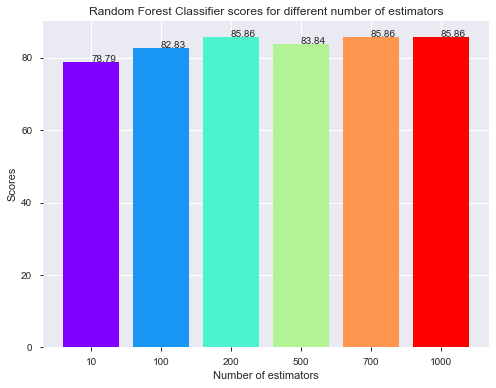

In [154]:
colors = rainbow(np.linspace(0, 1, len(estimators)))
plt.bar([i for i in range(len(estimators))], rf_scores, color = colors, width = 0.8)
for i in range(len(estimators)):
    plt.text(i, rf_scores[i], rf_scores[i])
plt.xticks(ticks = [i for i in range(len(estimators))], labels = [str(estimator) for estimator in estimators])
plt.xlabel('Number of estimators')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different number of estimators');

The maximum score is achieved at n_estimators= 200, 700 or 1000.

In [156]:
print("The score for Random Forest Classifier is {}% with {} estimators.".format(rf_scores[2], [200, 700,1000]))

The score for Random Forest Classifier is 85.86% with [200, 700, 1000] estimators.


### Naive Bayes

In [146]:
from sklearn.naive_bayes import GaussianNB
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = NB_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = NB_classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for Naive Bayes = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Naive Bayes = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))



Accuracy for training set for Naive Bayes = 0.797979797979798
Accuracy for test set for Naive Bayes = 0.7373737373737373


# Neural Network

In [43]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [44]:
model = Sequential()
model.add(Dense(11,activation='relu',input_dim=13))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [46]:
model.fit(X_train,y_train,epochs=300)

ValueError: Error when checking input: expected dense_1_input to have shape (13,) but got array with shape (28,)

### Conclusion

In this project, I used Machine Learning to predict whether a person is suffering from a heart disease. After importing the data, I analysed it using plots. Then, I did generated dummy variables for categorical features and scaled other features. 
I then applied four Machine Learning algorithms, `K Neighbors Classifier`, `Support Vector Classifier`, `Decision Tree Classifier` and `Random Forest Classifier`. I varied parameters across each model to improve their scores.
In the end, `K Neighbors Classifier` achieved the highest score of `87%` with `8 nearest neighbors`.